In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il
import glob
import itertools as it
import random
import warnings
import collections
import dill

from scipy import optimize


%load_ext ipydex.displaytools
%matplotlib inline


In [47]:
import stage_2a_bar_selection as bs
il.reload(bs)
from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,
    get_raw_cell,
    get_angle,
    correct_angle,
    rotate_img,
)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']



In [34]:
img_dir = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0"

hist_dict_path = "dicts"
total_res_fpath = f"{hist_dict_path}/_total_res.dill"
hist_dict_list = glob.glob(f"{hist_dict_path}/hist_*.dill")
hist_dict_list.sort()

In [17]:
tup = ("a", "6")

with open(total_res_fpath, "rb") as fp:
    total_res = dill.load(fp)

    
q_lower = total_res[tup]["q_lower"]
q_mid = total_res[tup]["q_mid"]
q_upper = total_res[tup]["q_upper"]

ii = np.arange(len(q_lower))



In [31]:
def decide_critical(cell_hist, q_lower, q_upper):
    mask1 = cell_hist < q_lower
    mask2 = cell_hist > q_upper
    
    # add upp critical areas
    # TODO: maybe this should be weighted
    area1 = np.sum(q_lower[mask1] - cell_hist[mask1])
    area2 = np.sum(cell_hist[mask2] - q_upper[mask2])
    
    res = area1 + area2
    # print(res)
    return res
    

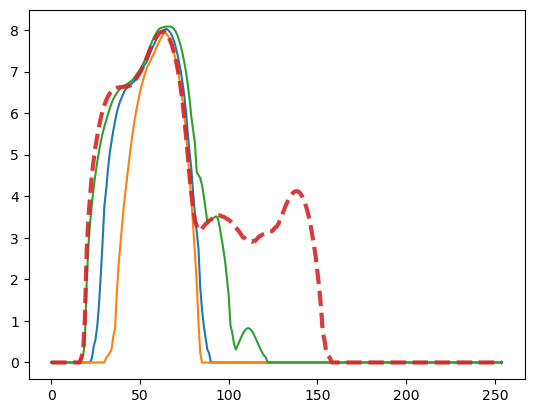

In [35]:
plt.plot(ii, q_mid)
plt.plot(ii, q_lower)
plt.plot(ii, q_upper)


suspect_fnames = []

res = collections.defaultdict(list)
for hist_dict_path in hist_dict_list:
    with open(hist_dict_path, "rb") as fp:
        hist_dict = dill.load(fp)
        

    cell_hist = hist_dict[tup][0]
    critical_area = decide_critical(cell_hist, q_lower, q_upper)
    if 20 < critical_area:
        plt.plot(ii, cell_hist, alpha=0.9, lw=3, ls="--")
        suspect_fnames.append(hist_dict_path.replace("dicts/hist_", f"{img_dir}/").replace(".dill", ".jpg"))
        
    
    

In [36]:
suspect_fnames

['/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-19-52_C50.jpg']

0.6499999999999798


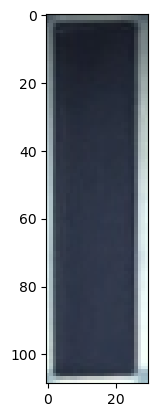

In [40]:
bar_img = select_bar_from_file(suspect_fnames[0], *tup)
plt.imshow(bar_img)

In [55]:
il.reload(bs)
dc = bs.Container()

_ = bs.get_symlog_hist(suspect_fnames[0], *tup, dc=dc)

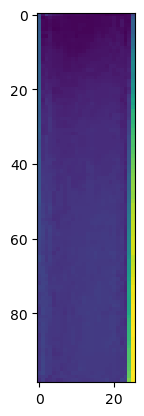

In [59]:
plt.imshow(dc.get_angle_image[:, 2:-2])

-0.5215056055815066

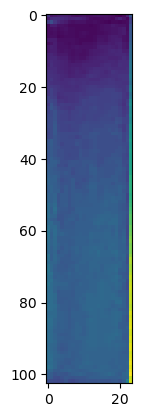

In [51]:
plt.imshow(dc.hist_img)
dc.angle

(bs.get_angle(avg_corrected_img)) := -0.3198350083739545

---

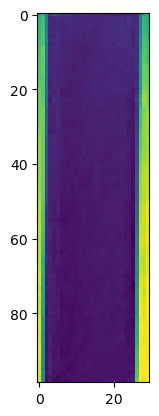

In [101]:
raw_img = dc.get_angle_image

mm = np.mean(raw_img, axis=1)

avg_corrected_img = raw_img - np.c_[mm]

bs.get_angle(avg_corrected_img) ##:


plt.imshow(avg_corrected_img)

In [63]:
a1 = bs.get_angle(dc.get_angle_image) ##:
a2 = bs.get_angle(dc.hist_img) ##:

a1 := -0.5215056055815066

---

a2 := -0.6421303935367257

---

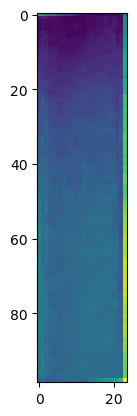

In [95]:
res2 = rotate_img(dc.get_angle_image, -(a1 + a2*0.5))
plt.imshow(res2[:, 3:-3])

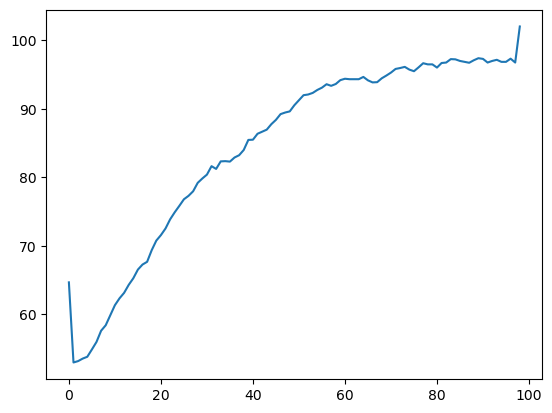

In [96]:
mm = np.mean(res2, axis=1)
plt.plot(mm)

(bs.get_angle(avg_corrected)) := 0.042121971515884746

---

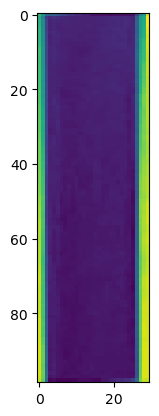

In [97]:
avg_corrected = res2 - np.c_[mm]

bs.get_angle(avg_corrected) ##:
plt.imshow(avg_corrected)

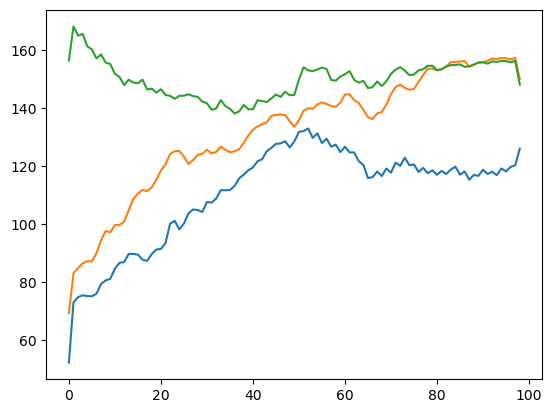

In [98]:
plt.plot(avg_corrected[:, -3:])

In [5]:


res = collections.defaultdict(list)
for hist_dict_path in hist_dict_list:
    with open(hist_dict_path, "rb") as fp:
        hist_dict = dill.load(fp)
        
    for k, v in hist_dict.items():
        res[k].extend(v)


# todo: this has the wrong data type        
bad_cells = res.pop("bad_cells")

In [23]:
font = \
{
    'color':  'tab:blue',
    'family': 'serif',
    'weight': 'normal',
    # 'fontname': "cmtt10",
    'size': 10,
    
}

There was an error in the displaytools extension (probably due to unsupported syntax).
This is the error message:

list index out of range

We leave this cell unchanged.


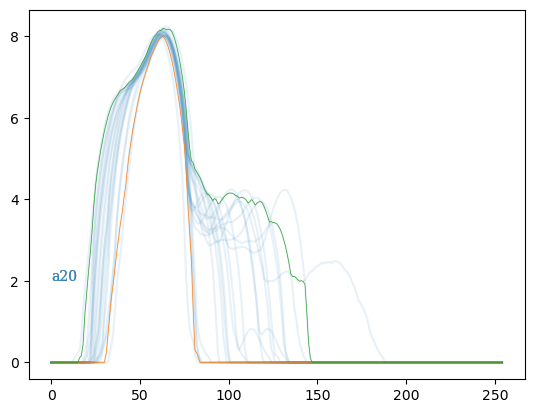

In [47]:
plt.rcParams['text.antialiased'] = True

total_res = {}

def process_hists(key, alpha=0.1, y_offset=0, save=True, plot=True):
    
    ii = np.arange(255)
    tup = (key[0], key[1:])
    for hist in res[tup]:
        plt.plot(ii, hist + y_offset, color="tab:blue", alpha=alpha)
        plt.text(0, y_offset + 2, f"{key}", fontdict=font, alpha=0.1)
        
    arr = np.array(res[tup])
    q_lower, q_mid, q_upper = np.quantile(arr, (0.05, 0.5, 0.95), axis=0)
    if plot:
        plt.plot(ii, q_lower + y_offset, color="tab:orange", lw=0.5)
        plt.plot(ii, q_upper+ y_offset, color="tab:green", lw=0.5)
        
    if save:
        total_res[tup] = {
            "q_lower": q_lower,
            "q_mid":  q_mid,
            "q_upper": q_upper,
        }

        
process_hists("a20")

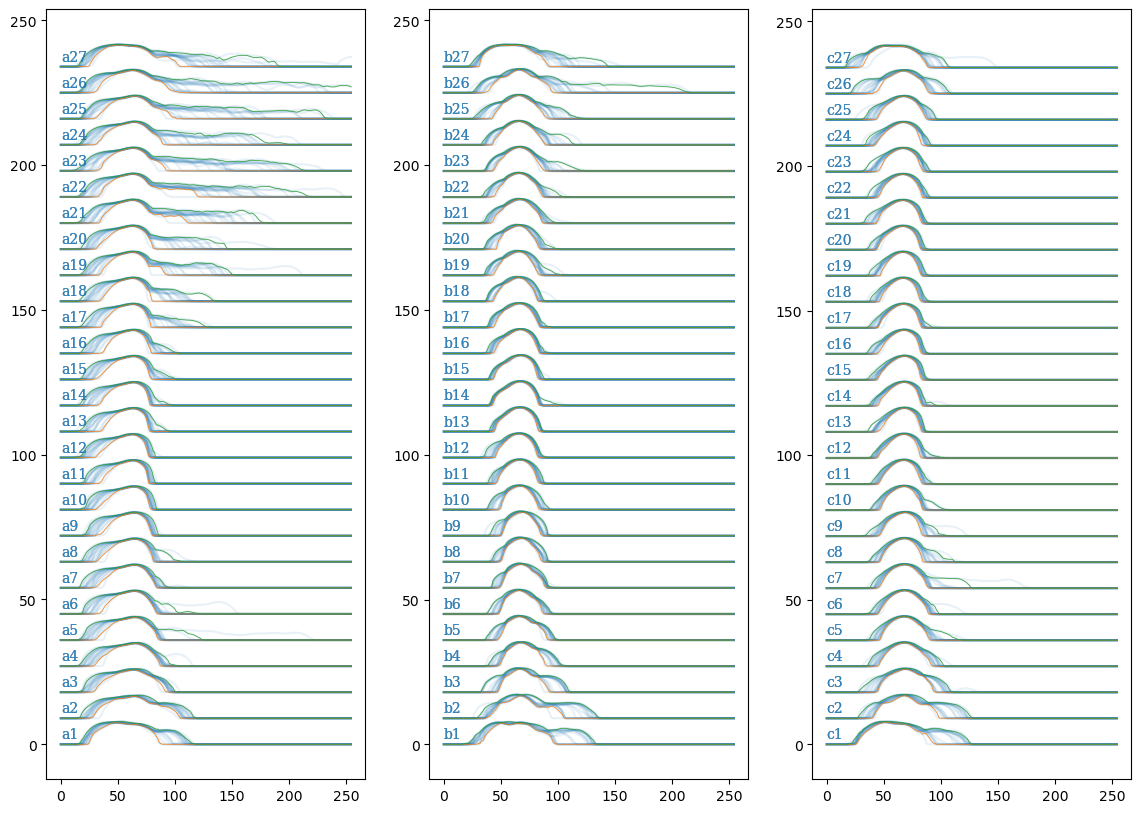

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(14, 10));

cell_tups = list(res.keys())

N = 27
for j in range(3):
    plt.sca(axes[j])
    for i, ct in enumerate(cell_tups[j*N:(j+1)*N]):
        process_hists("".join(ct), y_offset=i*9)
        

In [51]:
with open(total_res_fpath, "wb") as fp:
    dill.dump(total_res, fp)